# High Dynamic Range (HDR) Imaging

**Satya Mallick, LearnOpenCV.com**

!["HDR Image Example"](high-dynamic-range-hdr.jpg)

# Basic Idea

1. The **dynamic range** of images is limited to 8-bits (0 - 255) per channel
2. Very bright pixels saturate to 255
3. Very dark pixels clip to 0

# Step 1: Capture Multiple Exposures

!["HDR Image Sequence"](hdr-image-sequence.jpg)


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
DATA_PATH = "/Users/tawate/Library/CloudStorage/OneDrive-SAS/05_CDT_DataScience/data/OpenCV_Course_Data/"
def readImagesAndTimes():
  # List of file names  
  filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]
  
  # List of exposure times. This can be extracted programatically 
  times = np.array([ 1/30.0, 0.25, 2.5, 15.0 ], dtype=np.float32)
  
  # Read images 
  images = []
  for filename in filenames:
    im = cv2.imread(DATA_PATH + filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    images.append(im)
  
  return images, times


# Step 2: Align Images

![Aligned vs. Unaligned](aligned-unaligned-hdr-comparison.jpg)

In [3]:
# Read images and exposure times
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

# Step 3: Estimate Camera Response Function

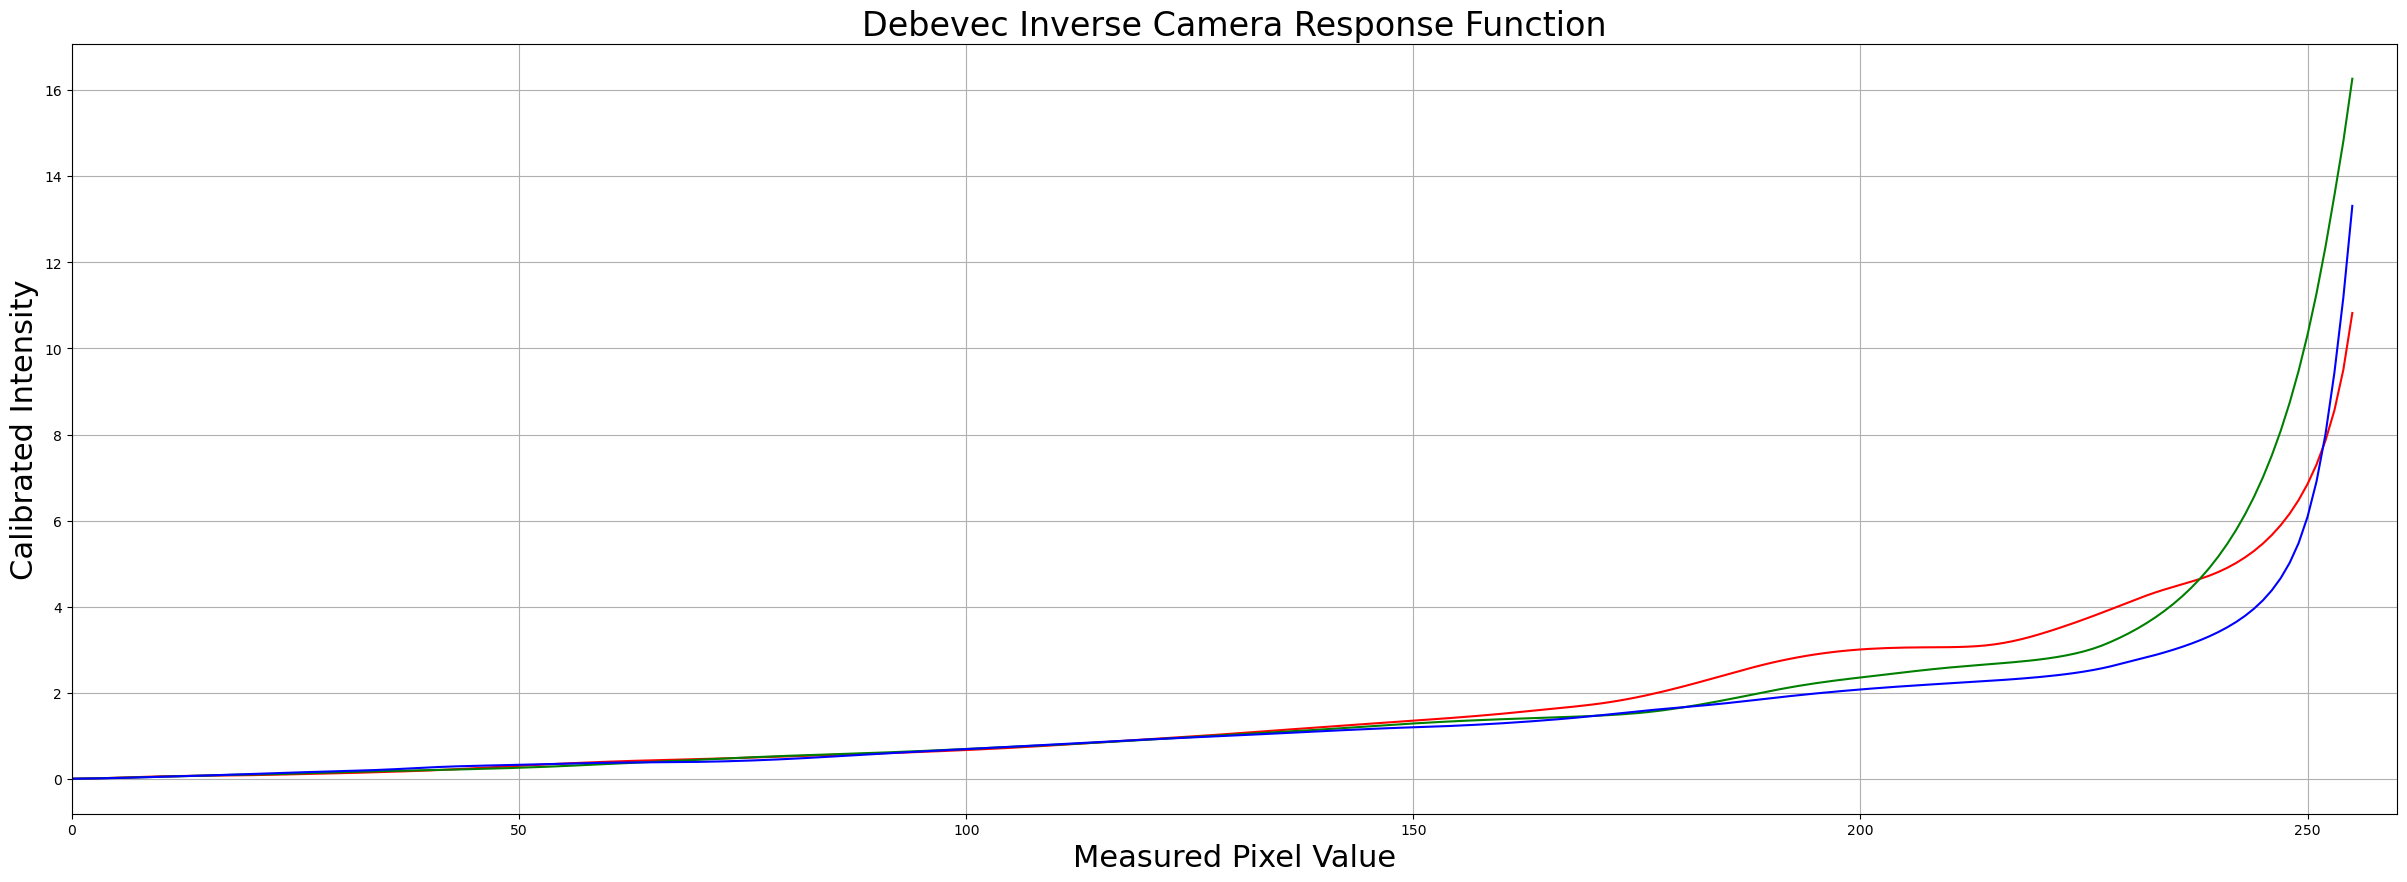

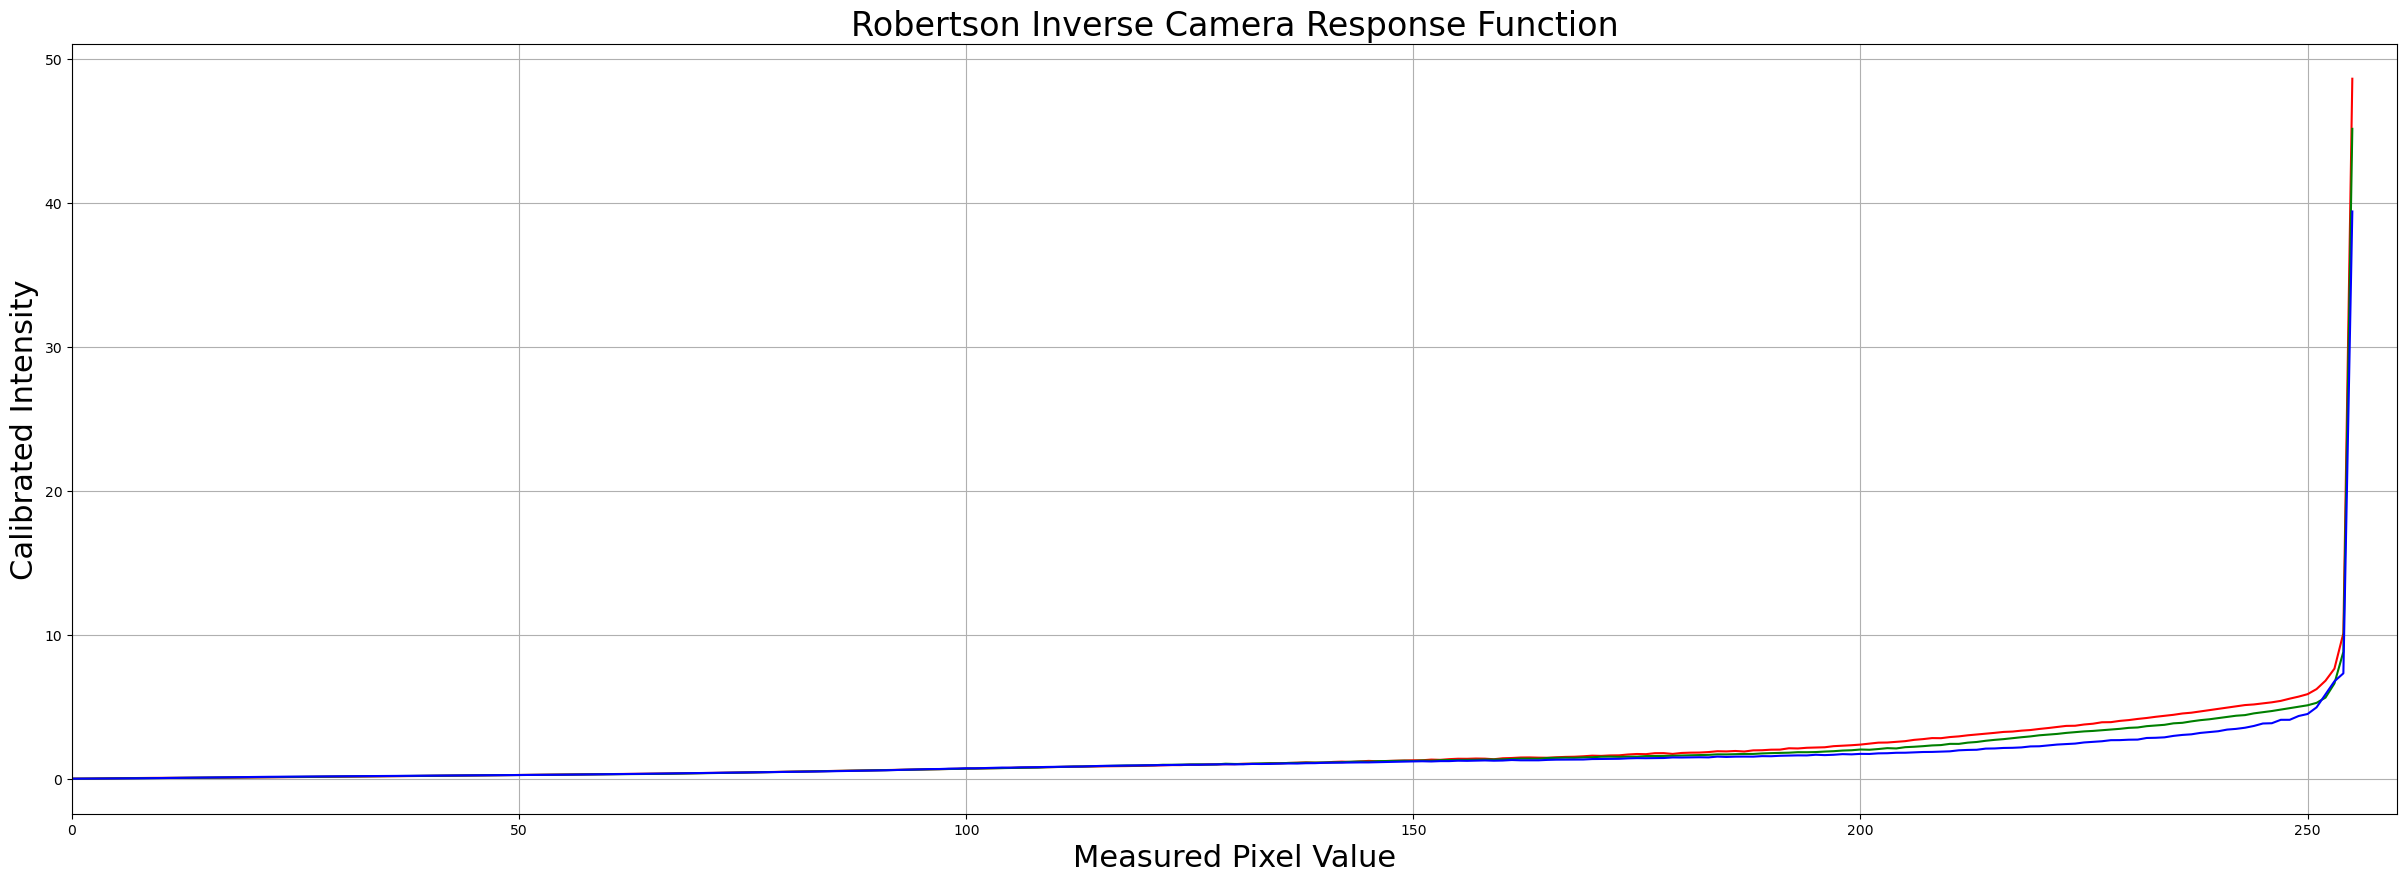

In [6]:
# Find Camera Response Function (CRF). 
# There isnt a 1 to 1 intensity to exposure scale, so a response function is needed to understand that relationship, in order to linearize prior to.
calibrateDebevec = cv2.createCalibrateDebevec()
calibrateRobertson = cv2.createCalibrateRobertson()
responseDebevec = calibrateDebevec.process(images, times)
responseRobertson = calibrateRobertson.process(images, times)

# Plot CRF for Debevec
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30,10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0,260])
plt.grid()
plt.plot(x, y[:,0],'r'  , x, y[:,1],'g', x, y[:,2],'b');

# Plot CRF for Robertson
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseRobertson)

ax = plt.figure(figsize=(30,10))
plt.title("Robertson Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0,260])
plt.grid()
plt.plot(x, y[:,0],'r'  , x, y[:,1],'g', x, y[:,2],'b');

# Step 4: Merge Exposure into an HDR Image

In [7]:
# Merge images into an HDR linear image
# Merging disregards pixel intensities close to 0 and 255
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

# Step 5: Tonemapping 

Many Tonemapping algorithms are available in OpenCV. We chose Durand as it has more controls.

[ WARN:0@1354.565] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/core/src/matrix_expressions.cpp (1334) assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739


saved ldr-Drago.jpg


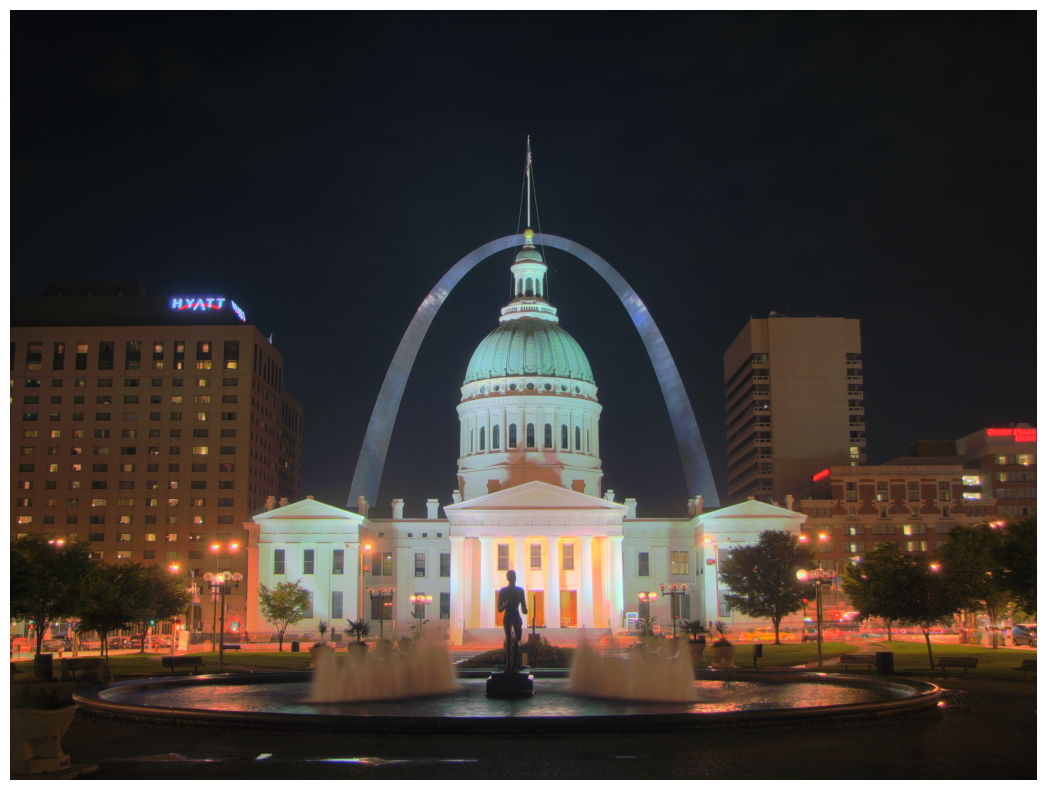

In [8]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrDrago,0,1)); plt.axis('off');
cv2.imwrite(DATA_PATH+"ldr-Drago.jpg", ldrDrago * 255)
print("saved ldr-Drago.jpg")


Tonemaping using Reinhard's method ... 
saved ldr-Reinhard.jpg


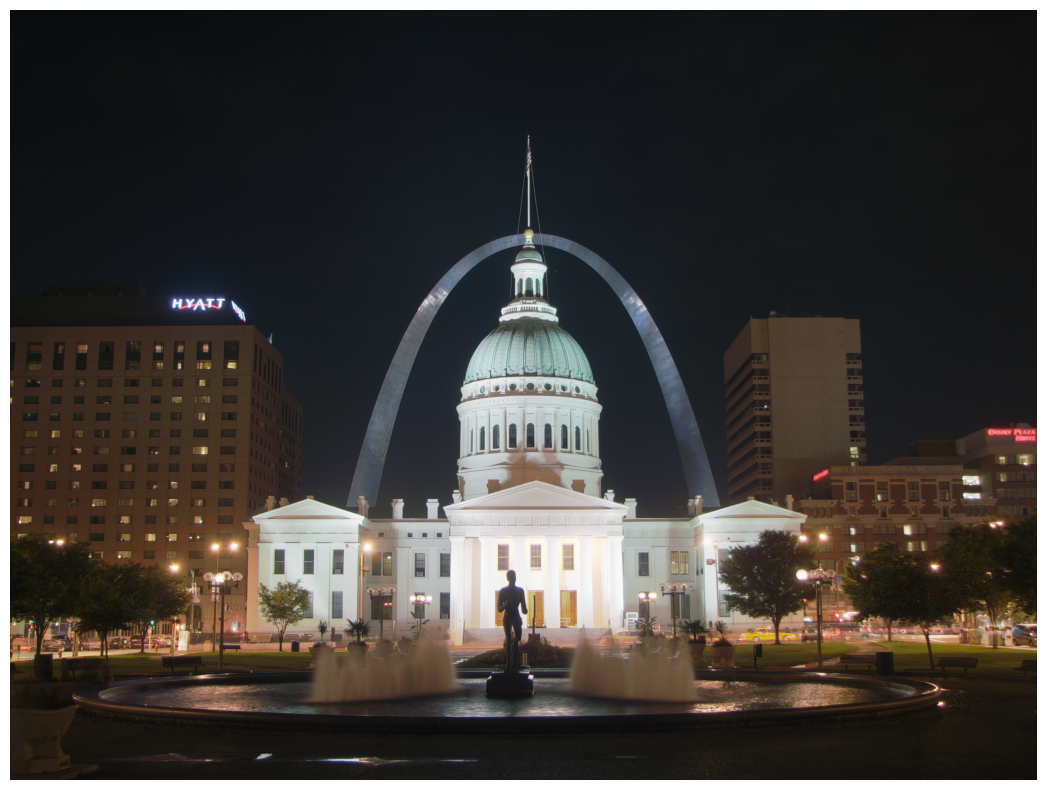

In [11]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0,0,0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrReinhard,0,1)); plt.axis('off');
cv2.imwrite(DATA_PATH+"ldr-Reinhard.jpg", ldrReinhard * 255)
print("saved ldr-Reinhard.jpg")

Tonemaping using Mantiuk's method ... 
saved ldr-Mantiuk.jpg


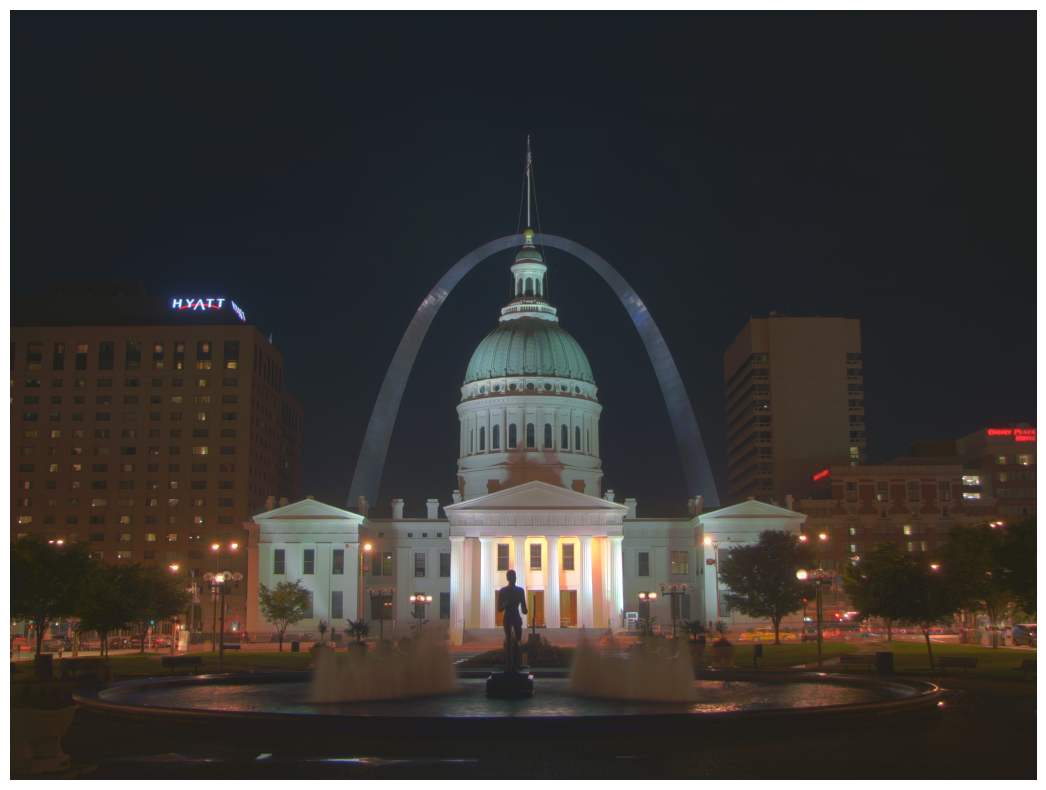

In [12]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2,0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrMantiuk,0,1)); plt.axis('off');
cv2.imwrite(DATA_PATH+"ldr-Mantiuk.jpg", ldrMantiuk * 255)
print("saved ldr-Mantiuk.jpg")